<a href="https://colab.research.google.com/github/Tclack88/DS-Unit-4-Sprint-1-NLP/blob/master/module1-text-data/LS_DS_411_Text_Data_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [0]:
!python -m spacy download en_core_web_lg

In [98]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [99]:
# Cleanup the data - all reviews start with a date, so I separate that out
import re

def cleanup(shop):
  shop.star_rating = shop.star_rating.apply(lambda x: int(x.strip()[0]))
  # shop['date'] = shop.full_review_text.apply(lambda x: x.split()[0])
  shop.full_review_text = shop.full_review_text.apply(lambda x: ' '.join(x.split()[1:]).lower())
  shop.full_review_text = shop.full_review_text.apply(lambda x: re.sub("[^a-z' ]",'',x))
  return shop

cleanup(shops)

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,checkin love love loved the atmosphere every ...,5
1,The Factory - Cafe With a Soul,listed in date night austin ambiance in austin...,4
2,The Factory - Cafe With a Soul,checkin listed in brunch spots i loved the ec...,4
3,The Factory - Cafe With a Soul,very cool decor good drinks nice seating howev...,2
4,The Factory - Cafe With a Soul,checkin they are located within the northcros...,4
...,...,...,...
7611,The Steeping Room,i actually step into this restaurant by chance...,4
7612,The Steeping Room,ok the steeping room is awesome how do they ha...,5
7613,The Steeping Room,loved coming here for tea and the atmosphere w...,4
7614,The Steeping Room,the food is just average the booths didn't fee...,3


In [0]:
import spacy
nlp = spacy.load('en_core_web_lg')
tokenizer = spacy.tokenizer.Tokenizer(nlp.vocab)

In [0]:
common_words = ['checkin', 'checkins', 'listed', 'coffee', 'shop', 'latte', 'tea', 'austin', ' ',"it's", "i'm", "i'd", "i've", "you're", "that's", "they're", "there's"]
STOP_WORDS = nlp.Defaults.stop_words.union(common_words)

tokens = []
for doc in tokenizer.pipe(shops.full_review_text):
  doc_tokens = [token.lemma_.lower() for token in doc 
                if (token.text.lower() not in STOP_WORDS) & (token.is_punct == False) ]
  tokens.append(doc_tokens)

shops['tokens'] = tokens

In [369]:
shops

,coffee_shop_name,full_review_text,star_rating,tokens
0,The Factory - Cafe With a Soul,checkin love love loved the atmosphere every ...,5,"[love, love, love, atmosphere, corner, style, ..."
1,The Factory - Cafe With a Soul,listed in date night austin ambiance in austin...,4,"[date, night, ambiance, beautiful, love, ambia..."
2,The Factory - Cafe With a Soul,checkin listed in brunch spots i loved the ec...,4,"[brunch, spot, love, eclectic, homey, plush, d..."
3,The Factory - Cafe With a Soul,very cool decor good drinks nice seating howev...,2,"[cool, decor, good, drink, nice, seat, overpri..."
4,The Factory - Cafe With a Soul,checkin they are located within the northcros...,4,"[locate, northcross, mall, shop, center, face,..."
...,...,...,...,...
7611,The Steeping Room,i actually step into this restaurant by chance...,4,"[actually, step, restaurant, chance, favorite,..."
7612,The Steeping Room,ok the steeping room is awesome how do they ha...,5,"[okay, steep, room, awesome, great, menu, item..."
7613,The Steeping Room,loved coming here for tea and the atmosphere w...,4,"[love, come, atmosphere, pretty, fresh, order,..."
7614,The Steeping Room,the food is just average the booths didn't fee...,3,"[food, average, booth, didn't, feel, clean, wa..."


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

### Strategy:
- Group the tokens by star rating
- Find the most common words for each review
- Ignore words common in __ALL__ other rating categories from the one being considered(this can be achieved by subtracting sets of words)

In [0]:
from collections import Counter

In [378]:
def flatten(lst):
  """ utility to reduce liists of lists to a single list """
  return sum( ([x] if not isinstance(x, list) else flatten(x) for x in lst), [] )

reviews = []

n_considered = 100

for i in range(5):
  top_words = Counter(shops.groupby('star_rating').tokens.sum().iloc[i])
  most_common = top_words.most_common(n_considered)
  reviews.append(most_common)


for i in range(len(reviews)):
  print(f'Top words found exclusively* in {i +1} star rating:')
  others = reviews.copy()
  review = others.pop(i)
  
  others = set([word for word,count in flatten(others)])
  review = set([word for word,count in review])
  unique_words = review - others

  for word in unique_words:
    print(f'\t{word}')

print(f"\n*exclusively that is considering the top {n_considered} words in each category")

Top words found exclusively* in 1 star rating:
	tip
	buy
	pay
	start
	rude
	employee
	puff
	understand
	today
	owner
	eat
	girl
	doesn't
	bring
Top words found exclusively* in 2 star rating:
	isn't
	won't
	shop
Top words found exclusively* in 3 star rating:
	kind
	decent
	hang
	probably
Top words found exclusively* in 4 star rating:
	house
	outdoor
	patio
	plenty
	light
	night
	chicken
Top words found exclusively* in 5 star rating:
	amaze
	awesome
	bean
	local
	gelato
	fresh
	tacos
	town
	live
*exclusively that is considering the top 100 words in each category


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Strategy:
- Find a large number of words common between good and bad reviews
- Get the words common to both
- Find the difference
- Look at the extreme ends (to get the top 10 positive and 10 negative common words)
- barplot for visualization

In [0]:
good_shops = shops[shops['star_rating'] >= 4]
bad_shops = shops[shops['star_rating'] < 4]

good_words_count = Counter(good_shops.tokens.sum()).most_common(8000)
bad_words_count = Counter(bad_shops.tokens.sum()).most_common(8000)

good_words = set(word for word,count in good_words_count)
bad_words = set(word for word,count in bad_words_count)

words_in_common = good_words.intersection(bad_words)

In [0]:
# Find the greatest differences between words found in good and bad reviews
differences = []
n_reviews = len(words_in_common)

for word in words_in_common:
  # difference is the relative fraction. i.e. difference of word occurence in 
  # "good" reviews and "bad" reviews
  difference = (dict(good_words_count)[word] / good_shops.shape[0] 
                - dict(bad_words_count)[word] / bad_shops.shape[0])
  differences.append((word,difference))

differences = dict(differences)
differences = sorted(differences.items(), key=lambda x: x[1], reverse=True)

In [0]:
differences  = pd.DataFrame(differences, columns = ['word','difference_in_count'])
top_10_pos_words = differences.head(10)
top_10_neg_words = differences.tail(10)
top_good_and_bad = pd.concat([top_10_pos_words,top_10_neg_words])

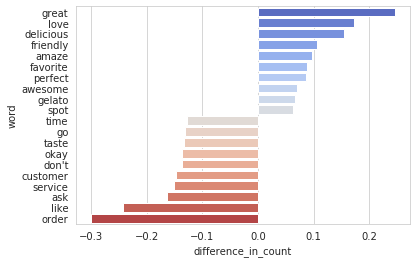

In [382]:
import seaborn as sb
sb.set_style('whitegrid')
sb.barplot(data=top_good_and_bad, y='word', x='difference_in_count',palette='coolwarm');

## Interpretation (based on key words):
*__Good__* coffee shops (obviously) have `delicious` coffee, made `perfectly`. The staff are `friendly` and It's in a good location (`spot`) for the customers. They may even serve `gelato` there.

*__Bad__* coffee shops are those in which customers have to `ask` for something that they shouldn't have. the coffe may only `taste` `ok`, and the `order` may not have been correct. Such places may have the customer waiting a longer `time` than expected.

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

